In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

In [2]:
test=pd.read_csv("dreaddit-test.csv")
train=pd.read_csv("dreaddit-train.csv")

In [3]:
train.columns

Index(['subreddit', 'post_id', 'sentence_range', 'text', 'id', 'label',
       'confidence', 'social_timestamp', 'social_karma', 'syntax_ari',
       ...
       'lex_dal_min_pleasantness', 'lex_dal_min_activation',
       'lex_dal_min_imagery', 'lex_dal_avg_activation', 'lex_dal_avg_imagery',
       'lex_dal_avg_pleasantness', 'social_upvote_ratio',
       'social_num_comments', 'syntax_fk_grade', 'sentiment'],
      dtype='object', length=116)

In [4]:
liwc_cols = [col for col in train.columns if col.startswith("lex_liwc_")]
print(liwc_cols)

['lex_liwc_WC', 'lex_liwc_Analytic', 'lex_liwc_Clout', 'lex_liwc_Authentic', 'lex_liwc_Tone', 'lex_liwc_WPS', 'lex_liwc_Sixltr', 'lex_liwc_Dic', 'lex_liwc_function', 'lex_liwc_pronoun', 'lex_liwc_ppron', 'lex_liwc_i', 'lex_liwc_we', 'lex_liwc_you', 'lex_liwc_shehe', 'lex_liwc_they', 'lex_liwc_ipron', 'lex_liwc_article', 'lex_liwc_prep', 'lex_liwc_auxverb', 'lex_liwc_adverb', 'lex_liwc_conj', 'lex_liwc_negate', 'lex_liwc_verb', 'lex_liwc_adj', 'lex_liwc_compare', 'lex_liwc_interrog', 'lex_liwc_number', 'lex_liwc_quant', 'lex_liwc_affect', 'lex_liwc_posemo', 'lex_liwc_negemo', 'lex_liwc_anx', 'lex_liwc_anger', 'lex_liwc_sad', 'lex_liwc_social', 'lex_liwc_family', 'lex_liwc_friend', 'lex_liwc_female', 'lex_liwc_male', 'lex_liwc_cogproc', 'lex_liwc_insight', 'lex_liwc_cause', 'lex_liwc_discrep', 'lex_liwc_tentat', 'lex_liwc_certain', 'lex_liwc_differ', 'lex_liwc_percept', 'lex_liwc_see', 'lex_liwc_hear', 'lex_liwc_feel', 'lex_liwc_bio', 'lex_liwc_body', 'lex_liwc_health', 'lex_liwc_sexual'

Dataset has already provided with many LIWC and lexical features. However, if all variables are to be used in logistic regression equation, redundancy and multicollinearity may be introduced, leading to unreliable estimates of coefficient values and lowered interpretability.

In [5]:
selected_features = [
    "lex_liwc_negemo",          # negative emotion
    "lex_liwc_anx",             # anxiety
    "lex_liwc_posemo",          # positive emotion
    "lex_liwc_cogproc",         # cognitive processing
    "lex_liwc_i",               # self focus
    "lex_liwc_work",            # work stress
    "lex_liwc_time",            # time pressure
    "lex_dal_avg_activation",   # emotional arousal
    "lex_dal_avg_pleasantness", # emotional valence
    "sentiment"                 # polarity score
]

Lexicon-based features derived from the Dictionary of Affect in Language (DAL) and LIWC were used to capture affective intensity and psychologically meaningful language patterns. Stress is expressed through negative emotion, anxiety language, high arousal, and low pleasantness so these features selected above complement semantic representations by providing interpretable emotional and cognitive indicators. And hence, the variables selected are LIWC and DAL variables, with sentiment included as well.

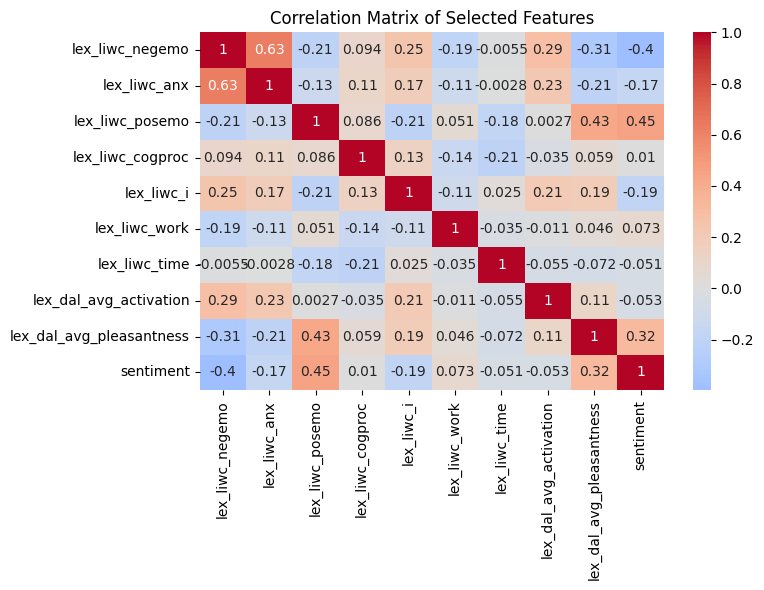

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

subset_train = train[selected_features]

corr_matrix = subset_train.corr()

plt.figure(figsize=(8, 6))

sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    center=0
)

plt.title("Correlation Matrix of Selected Features")
plt.tight_layout()
plt.show()

The correlation heatmap is created with selected vairables to determine the multicollinearity among the selected features. Using the correlation score of 0.8 as threshold, no pairs show such high correlation score. Therefore the coefficient estimates from the regression model are likely to be stable.

## Logistic Regression using selected_features

As the task is a binary classification problem, logistic regression provides a natural and well-establish model.  

In high-stakes domains such as mental health screening, interpretability is critical. Logistic regression allows direct inspection of feature coefficients, enabling identification of linguistic markers that contribute to stress prediction.  

This transparency supports clinical sense-making by revealing whether the model relies on psychologically meaningful features rather than superficial correlations.

In [7]:
y_train=train['label']
x_train=train[selected_features]
y_test=test['label']
x_test=test[selected_features]

In [8]:
model = LogisticRegression(class_weight="balanced",max_iter=1000)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
y_train_pred=model.predict(x_train)

f1_train=f1_score(y_train, y_train_pred)
f1 = f1_score(y_test, y_pred)
print("F1 test Score:", f1)
print("F1 train Score:", f1_train)

F1 test Score: 0.7526881720430108
F1 train Score: 0.7544097693351425


The logistic regression model achieves a test F1 score of 0.7527, indicating reasonably balanced precision and recall. The miniscule difference between F1 train score (0.7544) and F1 test score suggests that the model generalizes well and does not suffer from significant overfitting or underfitting. This indicates that the selected features provide consistent signals for distinguishing stressed and non-stressed posts.

#### Subreddit Level F1 Scores

In [9]:
print(train['subreddit'].unique())

['ptsd' 'assistance' 'relationships' 'survivorsofabuse' 'domesticviolence'
 'anxiety' 'homeless' 'stress' 'almosthomeless' 'food_pantry']


In [10]:
model.predict_proba(x_test)

array([[0.5917839 , 0.4082161 ],
       [0.69862171, 0.30137829],
       [0.65182233, 0.34817767],
       ...,
       [0.09444773, 0.90555227],
       [0.86330522, 0.13669478],
       [0.81482298, 0.18517702]], shape=(715, 2))

[('food_pantry', 1.0), ('stress', 0.8571428571428571), ('ptsd', 0.8333333333333334), ('anxiety', 0.8108108108108109), ('domesticviolence', 0.8), ('survivorsofabuse', 0.7246376811594203), ('relationships', 0.6495726495726496), ('assistance', 0.6486486486486487), ('almosthomeless', 0.5555555555555556), ('homeless', 0.42424242424242425)]


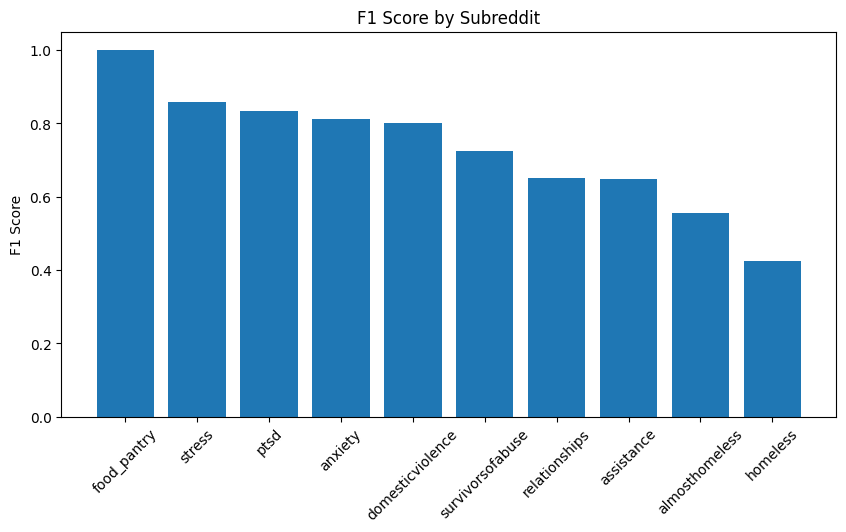

In [11]:
test_df = test.copy()
test_df['pred'] = model.predict(x_test)

# Compute F1 per subreddit
subreddit_scores = []

for sub in test_df['subreddit'].unique():
    subset = test_df[test_df['subreddit'] == sub]
    score = f1_score(subset['label'], subset['pred'])
    subreddit_scores.append((sub, score))

subreddit_scores = sorted(subreddit_scores, key=lambda x: x[1], reverse=True)
print(subreddit_scores)

sub_df = pd.DataFrame(subreddit_scores, columns=["Subreddit", "F1"])

plt.figure(figsize=(10,5))
plt.bar(sub_df["Subreddit"], sub_df["F1"])
plt.xticks(rotation=45)
plt.title("F1 Score by Subreddit")
plt.ylabel("F1 Score")
plt.show()


In [12]:
from sklearn.metrics import confusion_matrix

subset = test_df[test_df["subreddit"] == "food_pantry"]

print(confusion_matrix(
    subset["label"],
    subset["pred"]
))

[[3 0]
 [0 3]]


In [13]:
counts_test = test.groupby('subreddit').size().reset_index(name='Count_test')
print(counts_test)

          subreddit  Count_test
0    almosthomeless          19
1           anxiety         147
2        assistance          66
3  domesticviolence          72
4       food_pantry           6
5          homeless          52
6              ptsd         127
7     relationships         142
8            stress          14
9  survivorsofabuse          70


The F1 score for the food_pantry subreddit is 1.0, but this result should be interpreted with caution. The test set for this subreddit contains only 6 posts. The confusion matrix [[3, 0], [0, 3]] shows that the model correctly classified all 3 stressed and 3 non-stressed posts, resulting in a perfect score. However, because the sample size is so small, the result is not very reliable. If even one post had been misclassified, the F1 score would drop noticeably. Therefore, the perfect performance is likely due to the small number of examples rather than the model truly performing perfectly on this type of content.

Aside from food_pantry subreddit, subreddit-level performance shows that the model performs better in communities like stress, PTSD, anxiety, domestic violence, and survivors of abuse, where people openly talk about emotional pain and traumatic experiences. In these spaces, users often use strong emotional words and express high levels of distress. Since the model relies on features that measure negative emotion, anxiety-related language, and emotional intensity, it performs well when stress is clearly expressed in this way.

However, the model performs worse in subreddits such as homeless, almosthomeless, and assistance, which focus more on financial or housing problems. In these communities, people often describe their situations in a practical or factual way rather than using highly emotional language. Because the model mainly detects stress through emotional signals, it may struggle to recognise stress that is expressed more neutrally or indirectly.  

Furthermore, relationships subreddit is more ambiguous in terms of stress detection as while relationship issues can be emotionally intense, many posts involve storytelling, advice-seeking, or conflict descriptions that do not always contain strong negative emotional words. This mixture of emotional and situational content likely explains its moderate performance. It suggests that the model struggles when stress is embedded within complex interpersonal narratives rather than expressed directly.  

This indicates that the model performs best when stress is linguistically explicit, and less well when stress is contextual, relational, or embedded in narrative structure.

#### Feature Importance

                    feature  coefficient
7    lex_dal_avg_activation     0.606470
0           lex_liwc_negemo     0.226582
4                lex_liwc_i     0.178728
1              lex_liwc_anx     0.063089
5             lex_liwc_work     0.031739
3          lex_liwc_cogproc     0.025725
6             lex_liwc_time     0.000024
2           lex_liwc_posemo    -0.112386
9                 sentiment    -1.413786
8  lex_dal_avg_pleasantness    -2.403472


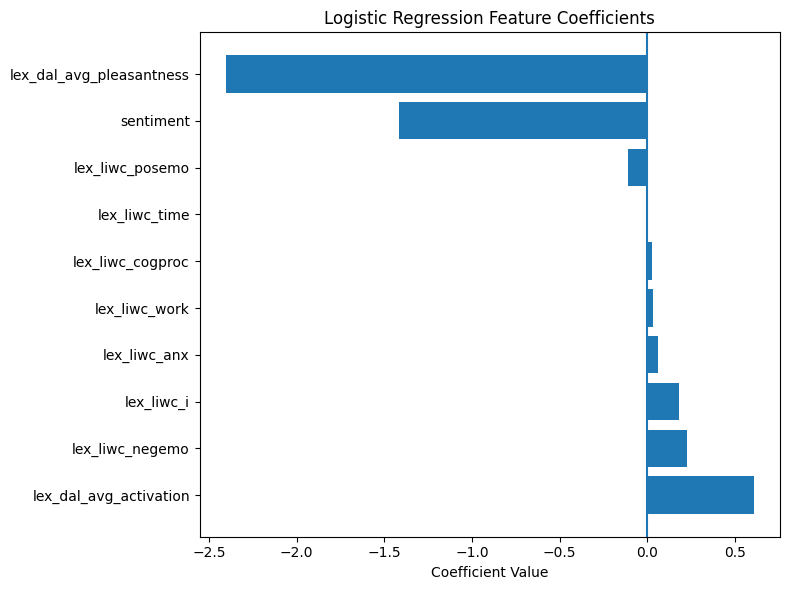

In [14]:
coefficients = model.coef_[0]

feature_importance = pd.DataFrame({
    "feature": selected_features,
    "coefficient": coefficients
})

# Sort by importance
feature_importance = feature_importance.sort_values(by="coefficient", ascending=False)

print(feature_importance)

plt.figure(figsize=(8,6))
plt.barh(feature_importance["feature"], feature_importance["coefficient"])
plt.axvline(0)
plt.title("Logistic Regression Feature Coefficients")
plt.xlabel("Coefficient Value")
plt.tight_layout()
plt.show()

The coefficients show that emotional tone is the strongest predictor of stress. In particular, lex_dal_avg_pleasantness (−2.40) and overall sentiment (−1.41) have the largest magnitudes, indicating that lower pleasantness and more negative sentiment strongly increase the probability of a post being classified as stressed. Emotional activation (lex_dal_avg_activation, +0.61) is also a strong positive predictor, suggesting that stressed posts tend to use more intense or aroused language. While negative emotion (lex_liwc_negemo, +0.23) and self-referential language (lex_liwc_i, +0.18) are associated with stress, their effects are smaller. Interestingly, situational features such as work (+0.03) and time pressure (0.000024) have minimal influence. This suggests that the model detects stress primarily through overall emotional intensity and reduced positivity rather than explicit mentions of stressors.

#### Failure Analysis

In [15]:
trim_df=test_df[["label", "pred"]]
temp_df=trim_df.copy()
temp_df["match"]=trim_df["label"]==trim_df["pred"]

trim_cm=confusion_matrix(temp_df["label"], temp_df["pred"])
print(trim_cm)

err=(trim_cm[0][1]+trim_cm[1][0])/sum(sum(trim_cm))
print("Error rate: ", err)

[[251  95]
 [ 89 280]]
Error rate:  0.2573426573426573


True Positive=280  
True Negative=251  
False Negative=89  
False Positive=95  

The fact that the number of false positives and false negatives are quite similar with error rate of 0.257 suggests that the model is not heavily biased towards prediciting whether the individual is stressed, not overly conservative and treats both classes of "stressed" and "not stressed" relatively symmetrically. This indicates there is stability.

In [16]:
error_df=test_df.copy()

pd.set_option('display.max_colwidth', None)

false_negatives = error_df[(error_df["label"] == 1) & (error_df["pred"] == 0)]
false_positives = error_df[(error_df["label"] == 0) & (error_df["pred"] == 1)]

print("\n--- Sample False Negatives ---")
print(false_negatives[["subreddit", "text"]].head(3))

print("\n--- Sample False Positives ---")
print(false_positives[["subreddit", "text"]].head(3))


--- Sample False Negatives ---
   subreddit  \
2       ptsd   
7    anxiety   
30   anxiety   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            text  
2   We'd be saving so much money with this new housr...its such an expensive city.... I did some googling in their language and found that it was illegal for them t

The false negatives, particularly from ptsd and anxiety, contain substantial distress but express it through situational descriptions rather than consistently high emotional intensity. For instance, one PTSD post describes contractual entrapment and fear of encountering an abusive ex, even stating “I wanna die,” yet much of the post is framed as detailed reasoning about housing legality. Similarly, an anxiety post focuses on sensory overload from roommates and a professor’s constant talking, and another describes social exhaustion from continuous obligations. Although these posts clearly convey psychological strain, they are embedded in contextual narration and cognitive explanation, which may dilute aggregate emotional feature values such as negative emotion or activation. This suggests that the model under-detects stress when it is expressed through prolonged situational hardship or cognitive framing rather than concentrated emotional intensity.  

In contrast, the false positives demonstrate the opposite tendency. A relationships post discussing jealousy and past romantic experiences, and anxiety posts about interview nervousness or disrupted sleep, contain elevated emotional language (e.g., “nervous,” “jealous,” “anxiety”) but do not necessarily reflect sustained psychological distress. These posts likely triggered higher activation or negative sentiment scores, leading the model to overgeneralize temporary emotional arousal as stress. For example, feeling nervous before an interview reflects anticipatory anxiety rather than chronic distress, yet the emotional cues resemble those found in genuinely stressed posts. Overall, the model appears biased toward detecting overt emotional intensity, while missing stress that is expressed through structured, explanatory, or situational narratives.

### Conclusion

The logistic regression model demonstrates that emotionally explicit language is a strong predictor of stress. By using LIWC, DAL, and sentiment features, it performs particularly well in trauma-focused communities where distress is clearly expressed. This suggests that the model could serve as an early screening tool in large-scale text analysis, such as monitoring anonymized “Let’s Talk” style discussions in Singapore. In such settings, it could help identify posts with strong emotional distress and prioritise them for further human review.

However, the model is less effective when stress is conveyed subtly or through factual descriptions of hardship rather than intense emotional wording. This means it may miss genuine cases of distress or incorrectly flag non-severe posts. As a result, the model should not be used as a standalone decision-making system. Instead, it should function as a supportive filtering tool with proper human oversight and ethical safeguards in place.

Github link to code: https://github.com/Ryan-WL/DSA4262